In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
nodetype_dict = {1:'soma', 2:'axon', 3:'dendrite', 4:'dendrite'}
color_dict = {1:'red', 2:'blue', 3:'limegreen', 4:'limegreen'}

In [3]:
file = 'neuron_shape_data/h_neocortex_interneuron_NMO_97216.txt'
df = pd.read_csv(file, sep = ' ', header=None, skipinitialspace = True)
df.columns = ['comp_id','type','x','y','z','radius','parent_id']
df

,comp_id,type,x,y,z,radius,parent_id
0,1,1,0.00,0.00,0.00,6.809,-1
1,4,3,0.92,3.75,-0.44,0.345,1
2,5,3,2.67,5.02,0.67,0.285,4
3,6,3,7.17,9.01,-0.44,0.230,5
4,7,3,9.49,11.57,-0.44,0.230,6
...,...,...,...,...,...,...,...
2321,2324,2,22.91,-26.74,-3.44,0.035,2323
2322,2325,2,22.55,-27.12,-3.44,0.035,2324
2323,2326,2,22.32,-27.16,-3.44,0.035,2325
2324,2327,2,20.97,-28.16,-3.99,0.035,2326


In [4]:
def edge_volume(input_df, node_id, parent_id):
    node_row = input_df.loc[input_df['comp_id'] == node_id]
    parent_row = input_df.loc[input_df['comp_id'] == parent_id]
    
    node_xyz = np.array([node_row['x'], node_row['y'], node_row['z']]).flatten()
    parent_xyz = np.array([parent_row['x'], parent_row['y'], parent_row['z']]).flatten()
    
    # volume of cylinder
    h = np.linalg.norm(node_xyz-parent_xyz)
    r = node_row['radius']
    
    return np.pi*r*r*h
    

In [5]:
G = nx.Graph()
for index, row in df.iterrows():
    G.add_node(int(row['comp_id']), nodetype = int(row['type']), radius = float(row['radius']))
    
for index, row in df.iterrows():
    if index > 0:
        G.add_edge(
            int(row['comp_id']), int(row['parent_id']), 
            volume = edge_volume(df, int(row['comp_id']), int(row['parent_id'])),
            edgetype = row['type']      
                  )
        
        
xy_coordinates = list(df[['x', 'y']].itertuples(index=False, name=None))
xy_coordinates = {row[0]: tuple(row[1:])[0] for row in zip(df['comp_id'], xy_coordinates)}

node_colors = [color_dict[t] for t in df['type']]

node_radius = np.array([row['radius'] for index, row in df.iterrows()])
node_radius = node_radius*(5/np.min(node_radius))

In [6]:
edge_volumes_and_types = ([(e[2]['volume'], int(e[2]['edgetype'])) for e in G.edges(data=True)])

axon_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] == 2])
dendrite_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] != 2])

soma_volume = (4/3)*np.power(list(G.nodes(data = True))[0][1]['radius'], 3)*np.pi

absolute_volumes = np.array([soma_volume, axon_volume, dendrite_volume]).round(2)
relative_volumes = np.round(absolute_volumes/np.sum(absolute_volumes), 2)


print('absolute volumes (s, a, d)', absolute_volumes)
print('relative volumes (s, a, d)', relative_volumes)

absolute volumes (s, a, d) [1322.33   24.68  493.44]
relative volumes (s, a, d) [0.72 0.01 0.27]


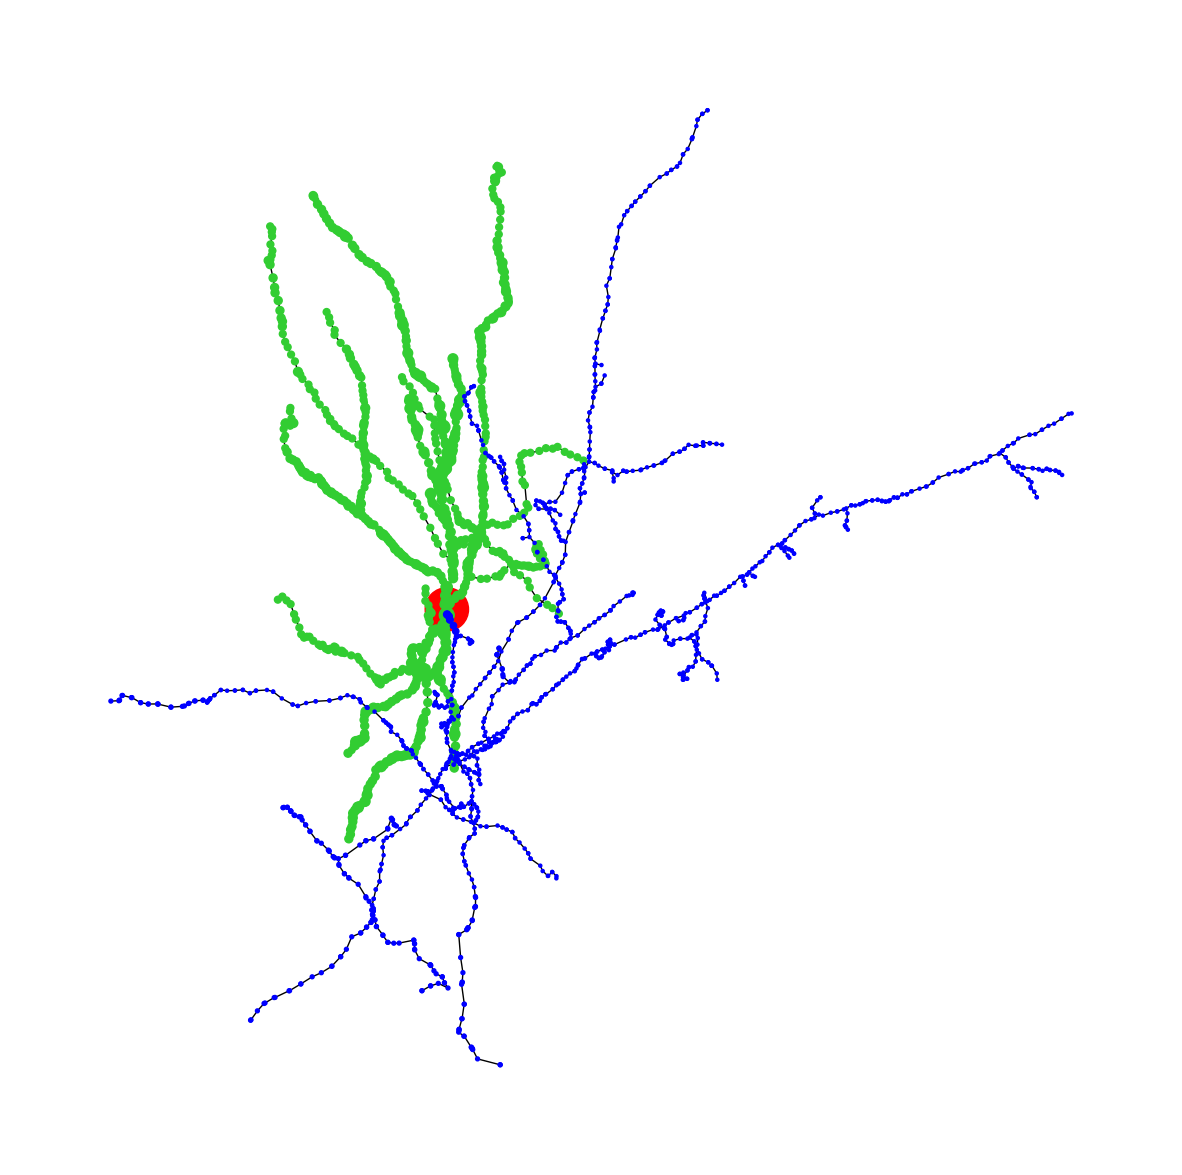

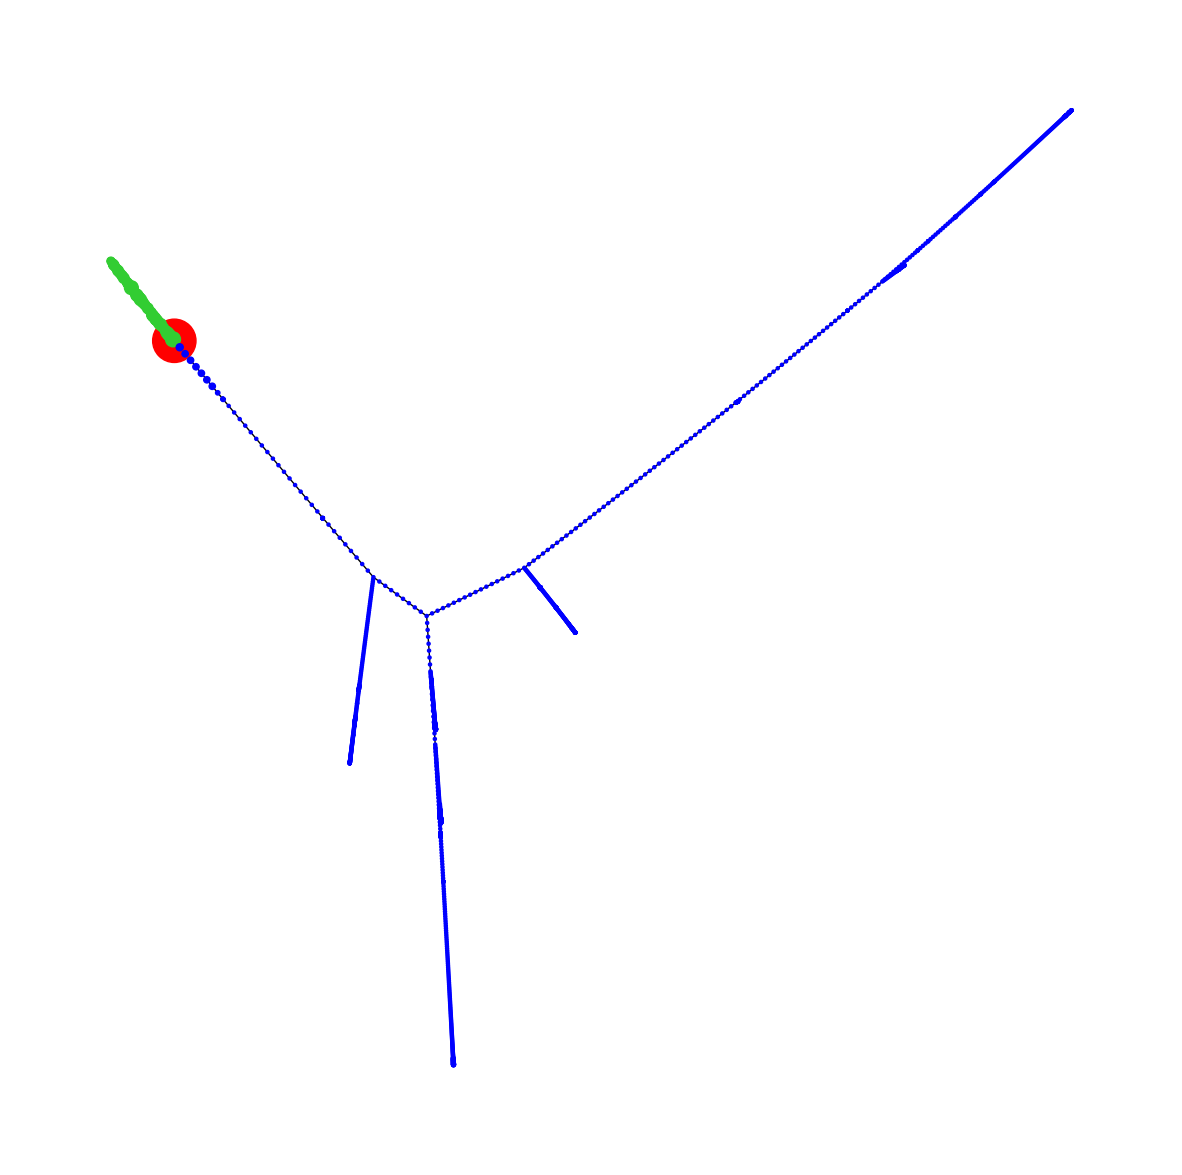

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(G, pos=xy_coordinates, node_size=node_radius, ax=ax, node_color = node_colors)

pos = nx.spectral_layout(G)

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(G, pos=pos, node_size=node_radius, ax=ax, node_color = node_colors)
plt.show()

In [8]:
leaf_nodes = [x for x in G.nodes() if G.degree(x)==1]
root_node = [leaf_nodes[0]]; leaf_nodes = leaf_nodes[1:]

branch_nodes = [x for x in G.nodes() if len(nx.descendants_at_distance(G, x, 1)) > 2]

transition_nodes = []
transition_node_index = []
for i, node in enumerate(G.nodes()):
    if (node not in leaf_nodes) and (node not in root_node) and (node not in branch_nodes):
        transition_nodes.append(node)
        transition_node_index.append(i)

for i in range(len(transition_nodes)):
    node = transition_nodes[i]
    bef, aft = nx.descendants_at_distance(G, node, 1)
    G.remove_node(node)
    G.add_edge(bef, aft)

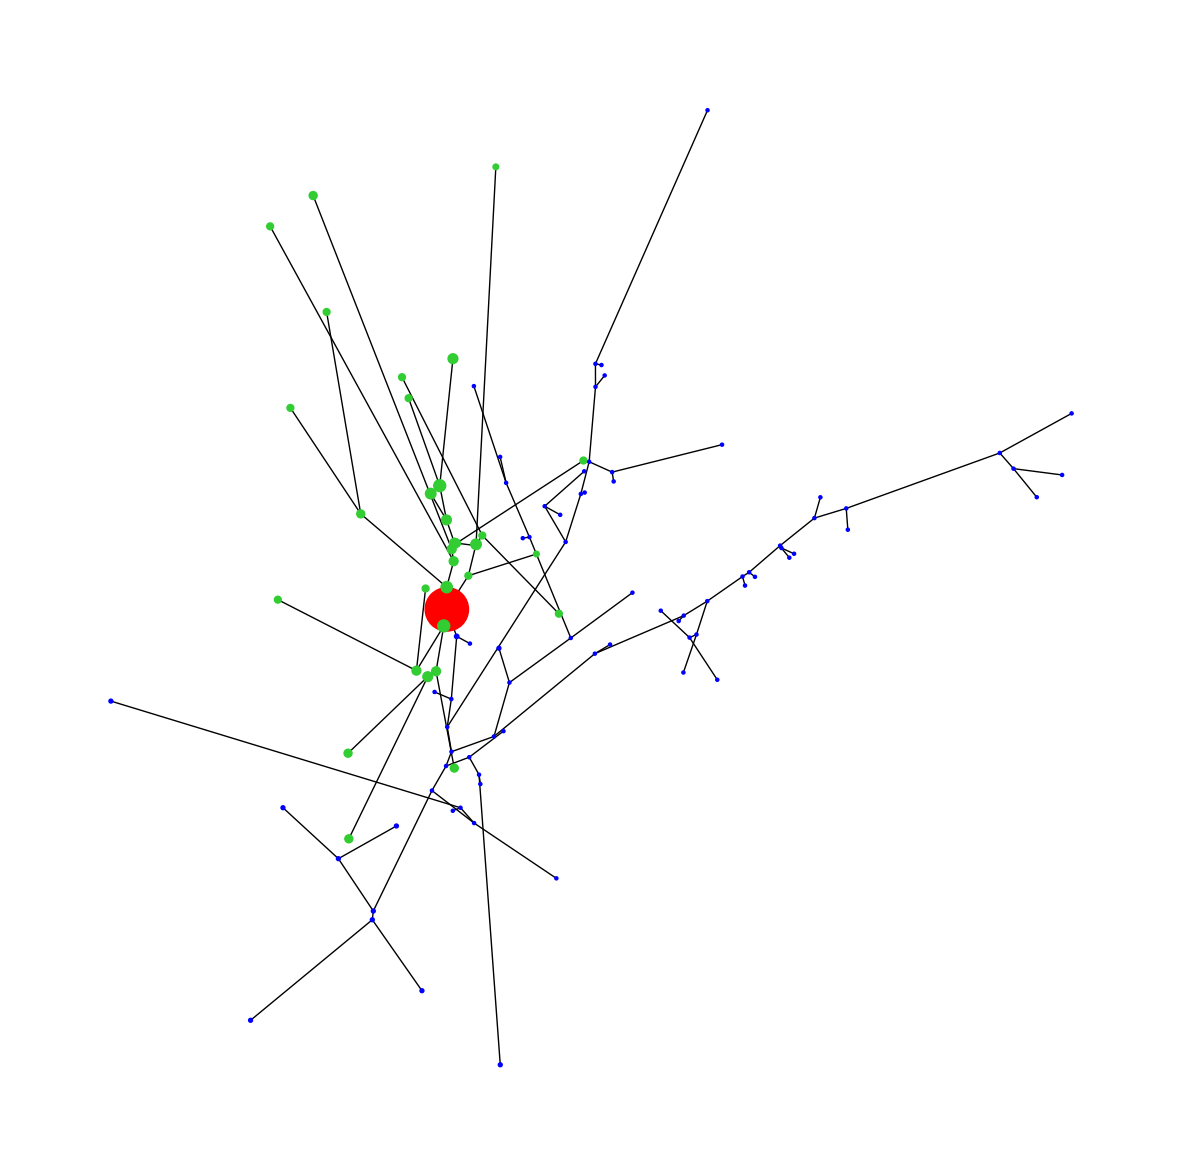

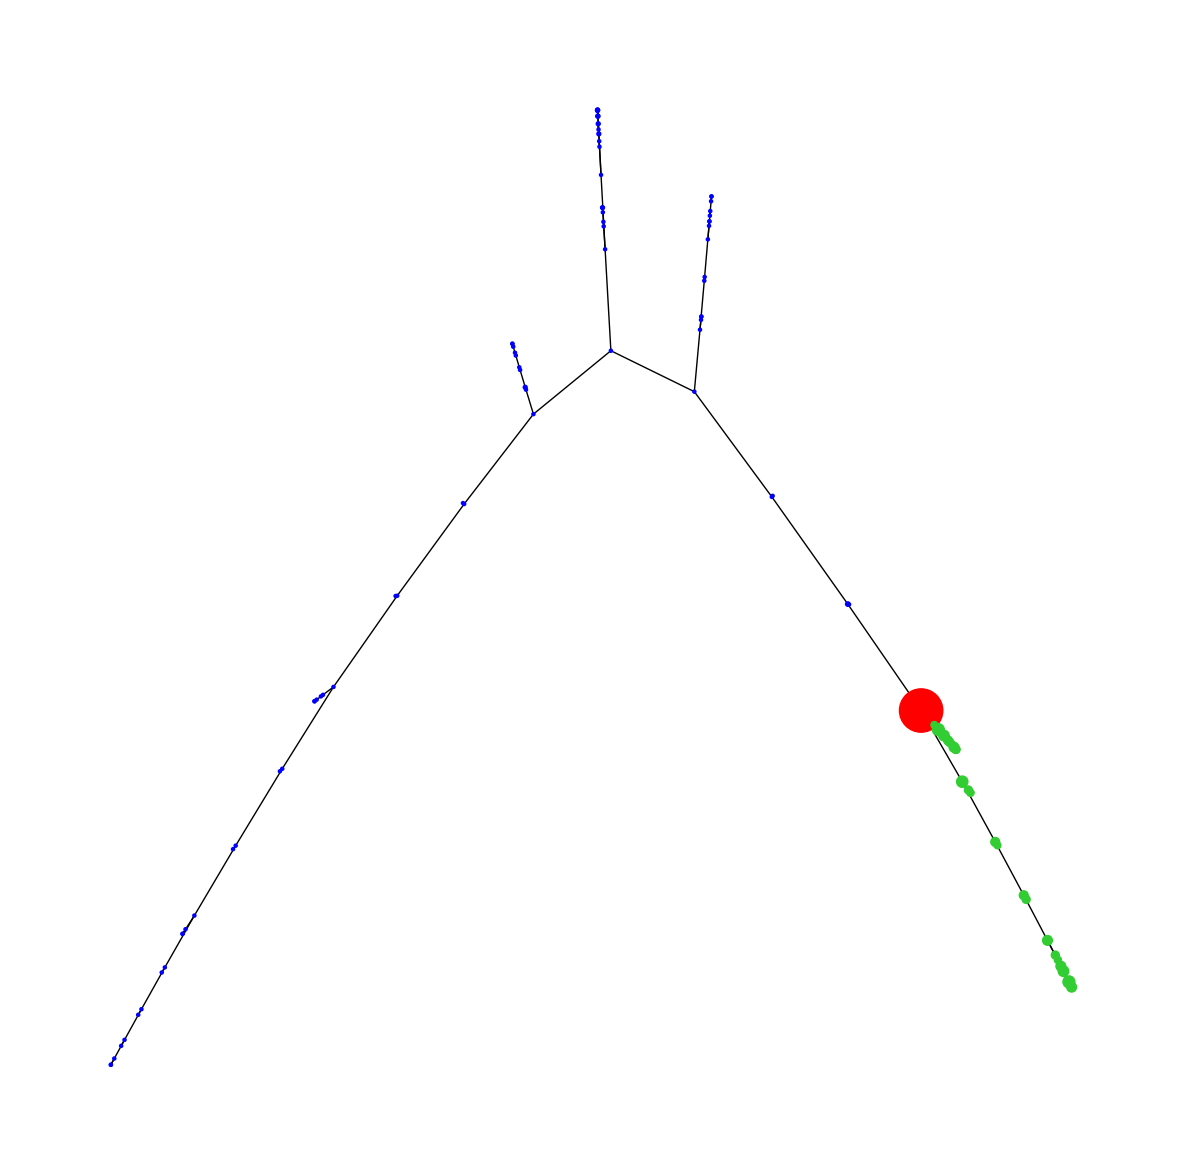

In [9]:
pos = nx.spectral_layout(G)

xy_coordinates = {element:xy_coordinates[element] for element in xy_coordinates if element not in transition_nodes}
node_colors = [element for i, element in enumerate(node_colors) if i not in transition_node_index]
node_radius = [element for i, element in enumerate(node_radius) if i not in transition_node_index]

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(G, pos=xy_coordinates, node_size=node_radius, ax=ax, node_color = node_colors)
plt.show()

fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(G, pos=pos, node_size=node_radius, ax=ax, node_color = node_colors)
plt.show()